In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!python3 -m pip install pyreadstat

In [3]:
!python3 -m pip install xlrd

In [4]:
text_to_val_df = pd.read_excel("../../data/Variablenwerte.xls", names=["Name", "Value", "Text"], header=1)
# Fill all names
for i in range(len(text_to_val_df)):
    if pd.isna(text_to_val_df.loc[i, "Name"]):
        text_to_val_df.loc[i, "Name"] = text_to_val_df.loc[i - 1, "Name"]
# make values ints
for i in range(len(text_to_val_df)):
    val = text_to_val_df.loc[i, "Value"]
    if val == ",00":
        val = 0
    elif val == "1,00":
        val = 1
    else:
        val = str(val).split(",")[0].replace(",", "")
        if val == "":
            print(i)
            val = -1
        else:
            val = int(val)
    text_to_val_df.loc[i, "Value"] = val
text_to_val_df

,Name,Value,Text
0,f1a_1,0,"no Ja, jemand mit positivem Test"
1,f1a_1,1,"Ja, jemand mit positivem Test"
2,f1a_2,0,"no Ja, jemand mit ärztlicher Diagnose, aber o..."
3,f1a_2,1,"Ja, jemand mit ärztlicher Diagnose, aber ohne ..."
4,f1a_3,0,"no Ja, jemand mit möglichen Symptomen, aber n..."
...,...,...,...
1209,bl,12,Brandenburg
1210,bl,13,Mecklenburg-Vorpommern
1211,bl,14,Sachsen
1212,bl,15,Sachsen-Anhalt


In [5]:
df = pd.read_spss("../../data/f20.0251z_290620.sav")
# replace strings by values using Variablenwerte.xls
replace_dict = {name: {row["Text"]: row["Value"] for _, row in text_to_val_df[text_to_val_df["Name"] == name].iterrows()} for name in text_to_val_df["Name"].unique()}
df = df.replace(replace_dict)
# replace empty rows by NaN
df = df.replace({"": np.nan, " ": np.nan})
# remove "offen" fields
df = df[[col for col in df if "offen" not in col]]
df

,sernr,f1a_1,f1a_2,f1a_3,f1a_4,f1a_5,f1a_6,f1b_1,f1b_2,f1b_3,...,f145,f146,altq,altqx,ges,plz,bl,regbez,lkrs,weight
0,1.0,0,0,0,0,1,0,0,0,0,...,NaN,2,67.0,5,2,972.0,9,6.0,77.0,0.947
1,2.0,0,0,0,0,1,0,0,0,0,...,NaN,2,54.0,4,2,844.0,9,1.0,77.0,0.880
2,3.0,0,0,0,0,1,0,0,0,0,...,NaN,2,67.0,5,2,985.0,16,0.0,66.0,1.051
3,4.0,0,0,0,0,1,0,0,0,0,...,NaN,2,26.0,2,1,453.0,5,1.0,13.0,2.233
4,6.0,0,0,0,0,1,0,0,0,0,...,NaN,2,50.0,4,1,703.0,8,1.0,11.0,0.923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30063,31676.0,0,0,0,0,1,0,0,0,0,...,NaN,1,53.0,4,1,168.0,12,0.0,68.0,0.853
30064,31677.0,0,0,1,0,0,0,0,0,1,...,NaN,2,31.0,2,1,732.0,8,1.0,16.0,1.015
30065,31678.0,0,0,0,0,0,1,0,0,0,...,NaN,2,44.0,3,2,42.0,14,7.0,13.0,0.787
30066,31679.0,0,0,0,0,1,0,0,0,0,...,NaN,2,41.0,3,1,11.0,14,6.0,12.0,0.870


# Preprocessing functions

In [6]:
sys.path.insert(0, '..') 

import constants

## Replace "don't know"

In [7]:
def dontknow_to_mean(df, columns):
    for c in columns:
        print(c, sum(df[c] == max(df[c])))
        df[c] = df[c].replace({max(df[c]) : round(df[c].mean())})
        print()
    return df

In [8]:
def dontknow_to_lowest(df, columns):
    for c in columns:
        print(c, sum(df[c] == max(df[c])))
        df[c] = df[c].replace({max(df[c]) : min(df[c])})
        print()
    return df

In [9]:
df = dontknow_to_mean(df, constants.ordinal_questions)

f5 28

f6 67

f7 13

f9 49

f10 60

f11 43

f12 52

f13 258

f14 0

f15 195

f16 0

f18 0

f19 39

f20 19

f21 46

f22 205

f23 37

f24 117

f25 114

f26 82

f27 50

f28 201

f29 64

f30 126

f31 143

f32 109

f37 259

f63 0

f64 0

f68 2822

f72 0

f89 290

f95 942

f96 185

f98 133

f99 220

f100 304

f102 147

f103 558

f104 325

f105 213

f106 444

f107 223

f108 340

f109 240

f110 77

f111 80

f112 70

f113 98

f114 87

f115 87

f116 90

f117 82

f118 161

f119 294

f120 156

f121 510

f122 247

f123 203

f124 340

f125 203

f126 269

f127 218

f128 70

f129 73

f130 74

f131 94

f132 81

f133 76

f134 82

f146 68



In [10]:
df = dontknow_to_lowest(df, constants.preconditions_when)

f135a 552

f135b 120

f135c 498

f135d 335

f135e 112

f135f 243

f135g 247

f135h 281

f135i 230

f135j 155

f135k 260

f135l 309

f135m 226

f135n 203

f135o 161

f135p 108

f135q 281

f135r 67



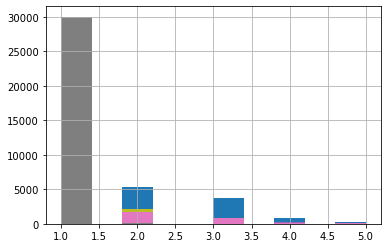

In [11]:
for c in constants.preconditions_when:
    df[c].hist()

## Replace numeric placeholders in interval-scale questions (99, 999, etc.)

In [12]:
def replace_nan_placeholder(df, text_to_val_df, columns):
    # replace 99, 999 etc. by np.nan
    for c in columns:
        nan_placeholder = text_to_val_df.loc[text_to_val_df['Name'] == c, 'Value'].to_list()[0]
        if c in df.columns:
            df[c] = df[c].replace(nan_placeholder, np.nan)
    return df

df = replace_nan_placeholder(df, text_to_val_df, constants.interval_questions)

<AxesSubplot:>

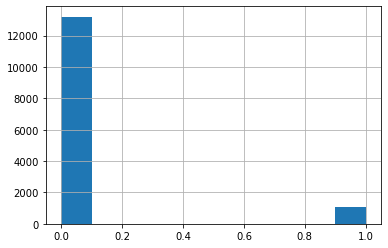

In [43]:
df.loc[df['ges_1']==1, 'target'].hist()

<AxesSubplot:>

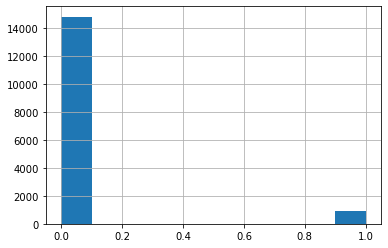

In [44]:
df.loc[df['ges_2']==1, 'target'].hist()

0    15821
1    14247
Name: ges_1, dtype: int64
1    15745
0    14323
Name: ges_2, dtype: int64
0    30040
1       28
Name: ges_3, dtype: int64
0    30020
1       48
Name: ges_4, dtype: int64


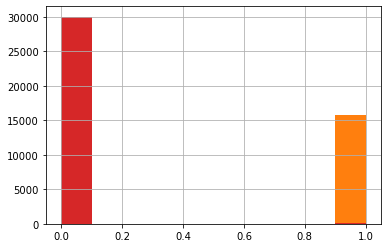

In [41]:
for c in ['ges_1', 'ges_2', 'ges_3', 'ges_4']:
    print(df[c].value_counts())
    df[c].hist()
    

## Apply one-hot encoding where necessary

In [13]:
def one_hot(df, columns):
    for c in columns:
        if c not in df.columns:
            print(f"{c} not in columns")
            break
        dummies = pd.get_dummies(df[c])
        dummies.columns = [f"{c}_{int(val)}" for val in sorted(dummies.columns)]
        dummies.columns[-1] = dummies.columns[-1] + '_nan'
        # also if nan, set last dummy to 1 (= "weiß nicht/ kA")
        if df[c].isna().sum() > 0:
            dummies.loc[df[c].isna(), dummies.columns[-1]] = 1
        df = df.drop(c, axis=1)
        df = pd.concat([df, dummies], axis=1)
    return df
    
for l in [constants.to_one_hot, constants.expect_change, constants.reduced_income, constants.age_kids, constants.not_always_applicable]:
    df = one_hot(df, l)

f65_1 not in columns


In [14]:
#df.select_dtypes(include=['category'])

count    30068.000000
mean         2.100106
std          0.984272
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: f5, dtype: float64
count    30068.00000
mean         2.38383
std          1.01872
min          1.00000
25%          2.00000
50%          2.00000
75%          3.00000
max          5.00000
Name: f6, dtype: float64
count    30068.000000
mean         3.898929
std          0.889697
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: f7, dtype: float64
count    30068.000000
mean         3.443728
std          1.165972
min          1.000000
25%          2.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: f9, dtype: float64
count    30068.000000
mean         2.338898
std          0.916195
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: f10, dtype: float64
co

<ipython-input-15-a69fc822d136>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


count    30068.000000
mean         3.736896
std          1.283397
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: f30, dtype: float64
count    30068.000000
mean         2.530464
std          1.102990
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: f31, dtype: float64
count    30068.000000
mean         1.970035
std          1.210095
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: f32, dtype: float64
count    30068.000000
mean         3.259212
std          1.054470
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: f37, dtype: float64
count    30068.000000
mean         2.969403
std          1.023420
min          1.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          9.000000
Name: f63, dtype

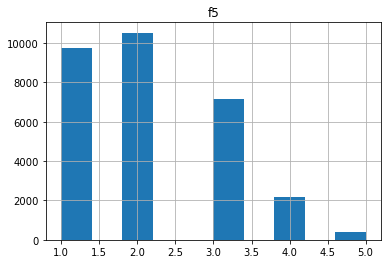

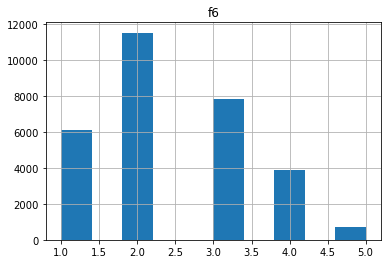

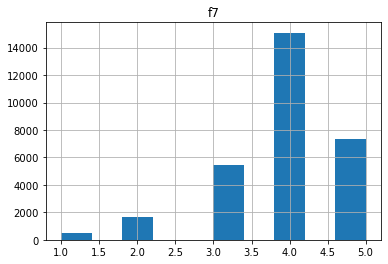

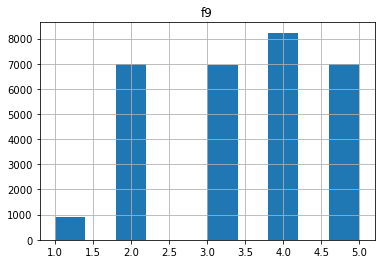

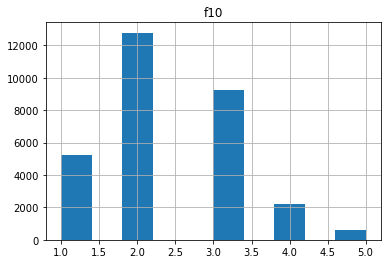

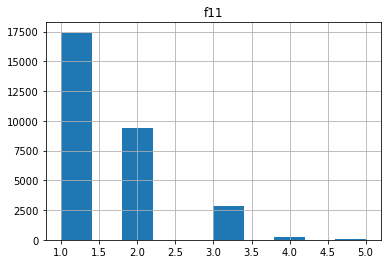

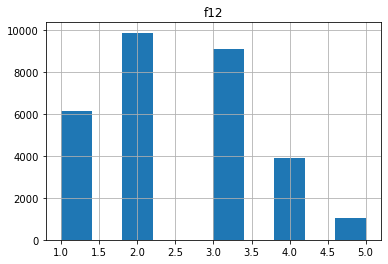

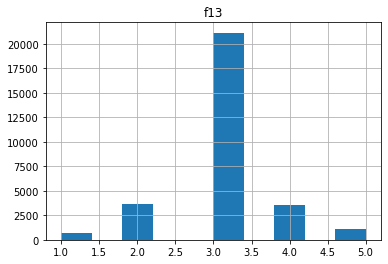

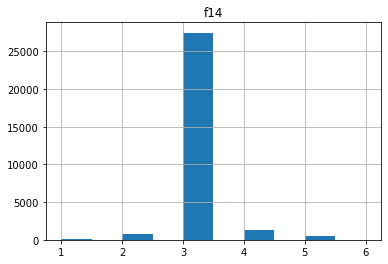

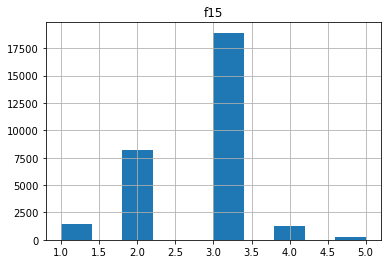

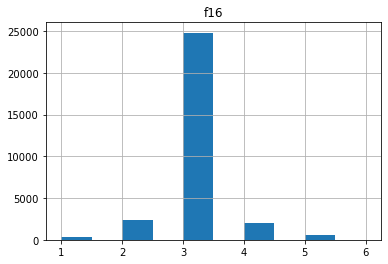

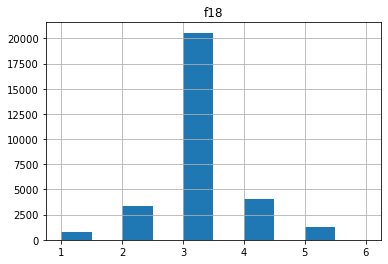

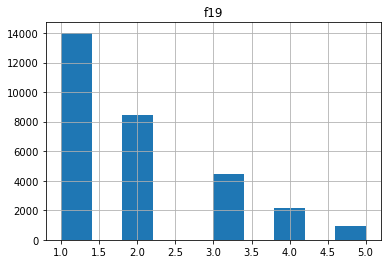

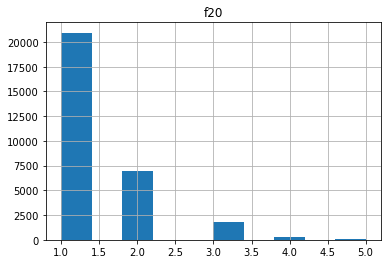

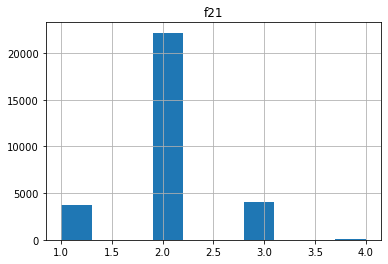

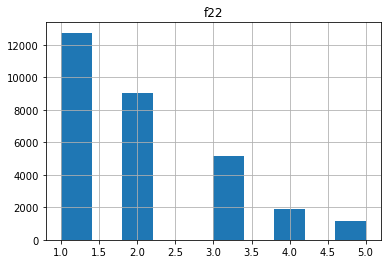

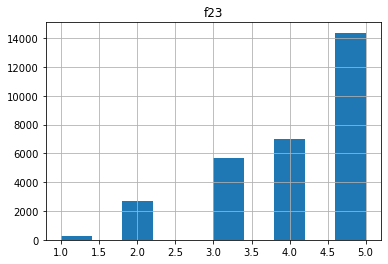

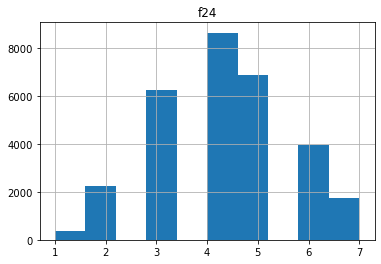

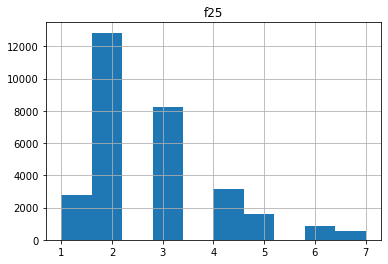

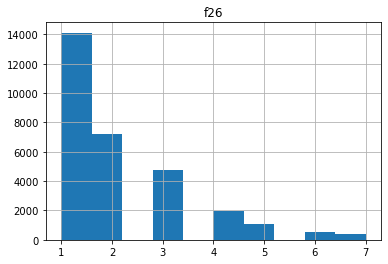

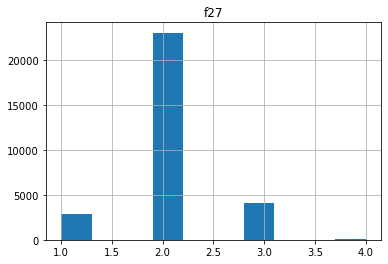

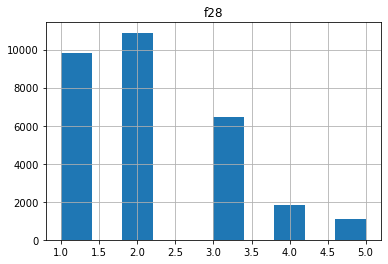

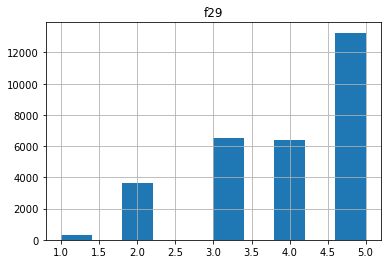

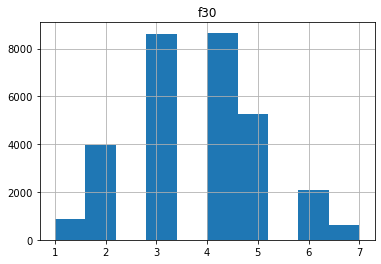

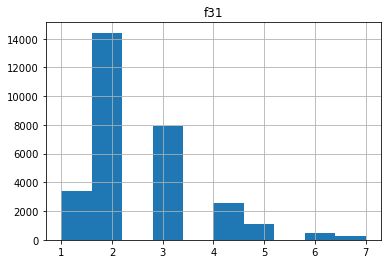

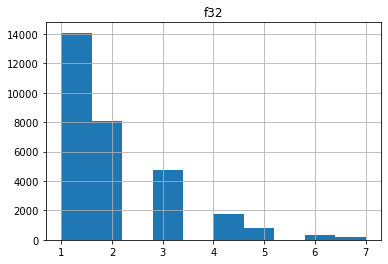

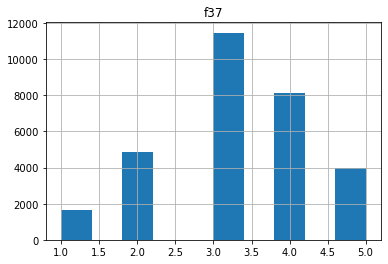

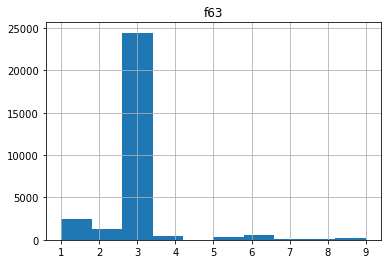

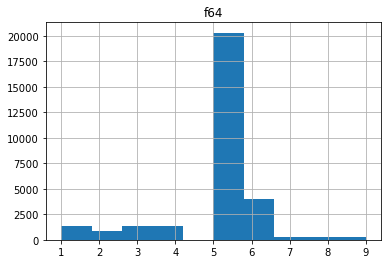

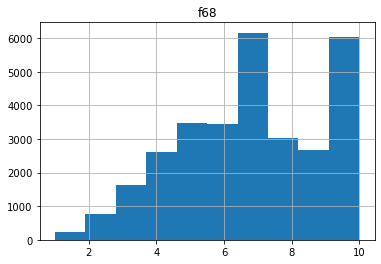

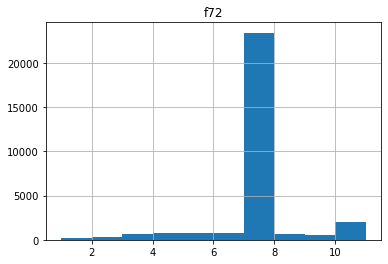

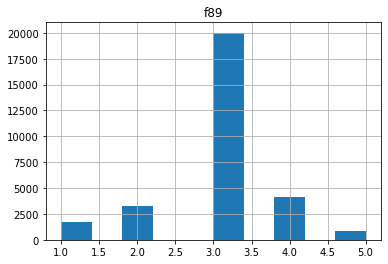

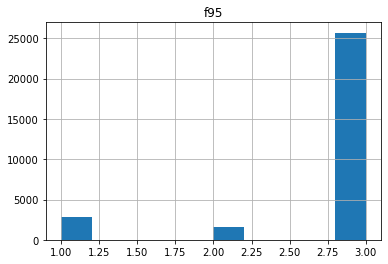

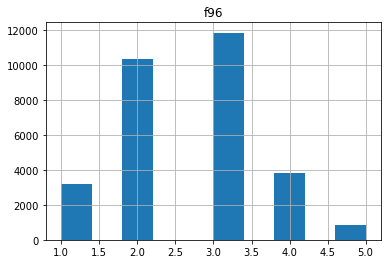

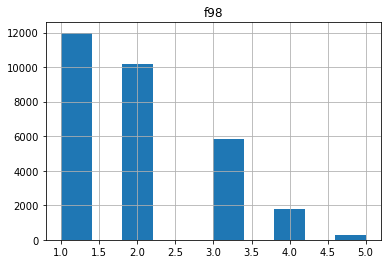

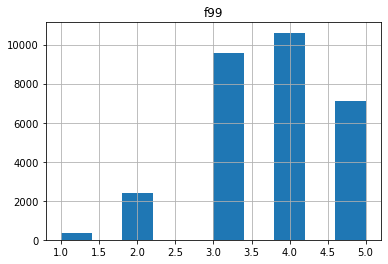

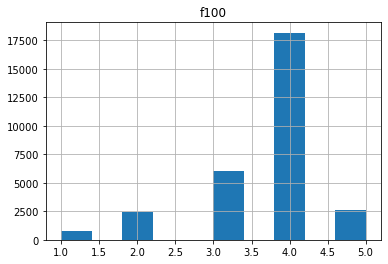

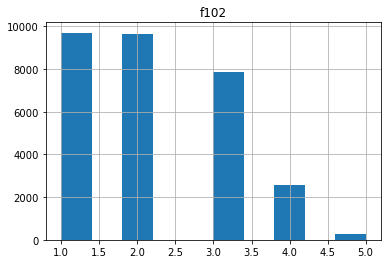

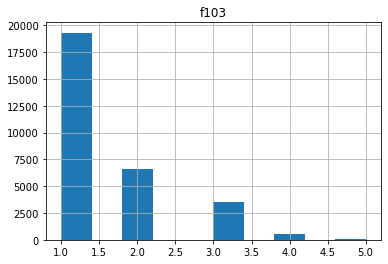

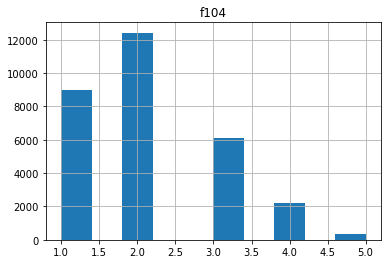

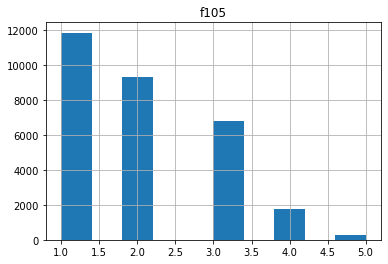

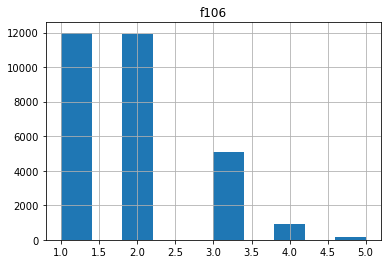

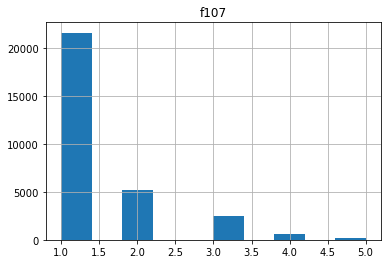

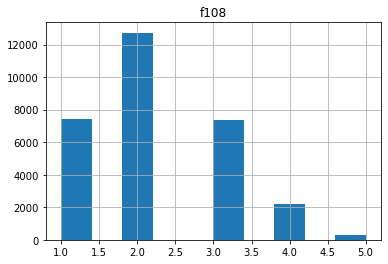

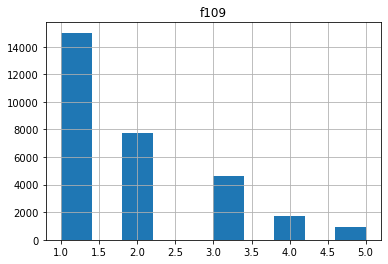

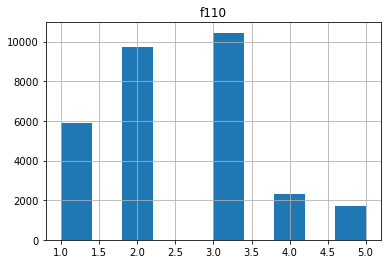

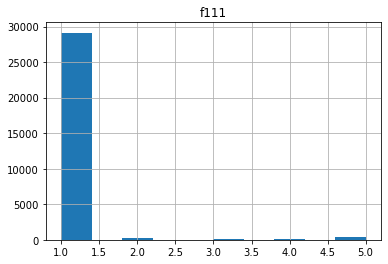

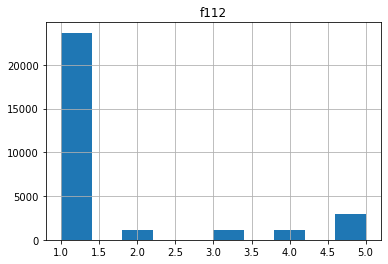

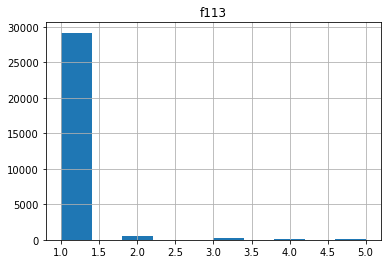

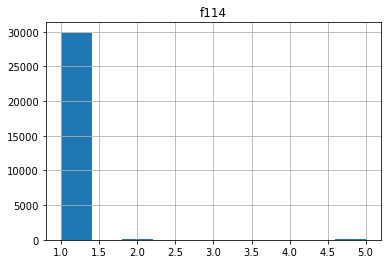

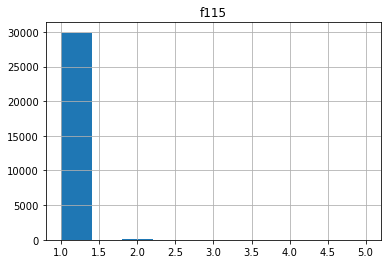

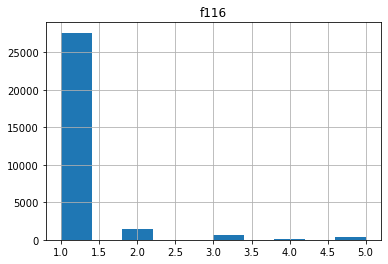

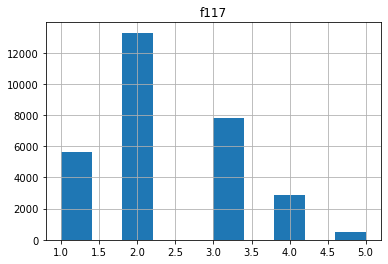

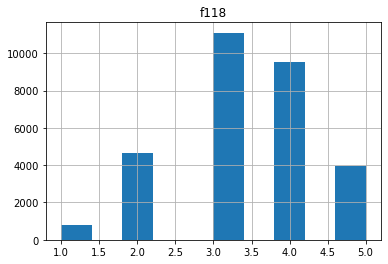

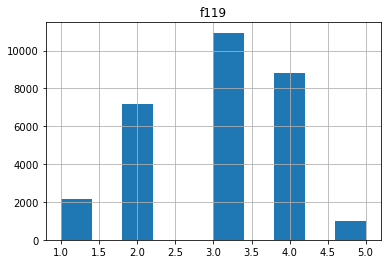

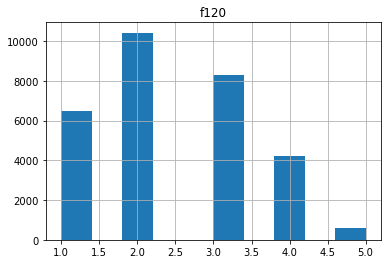

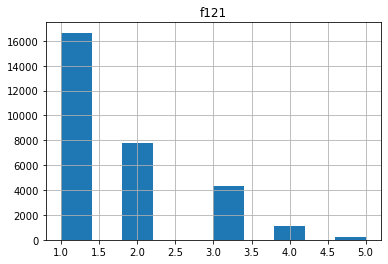

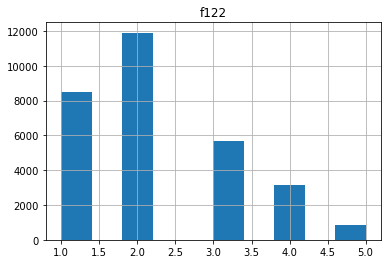

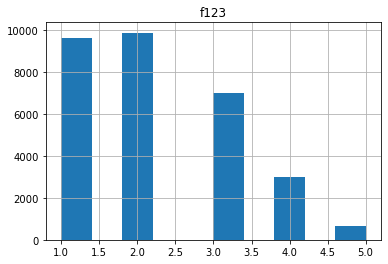

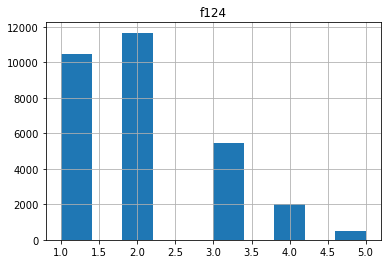

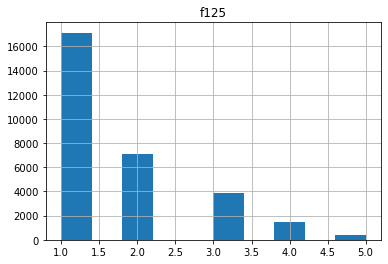

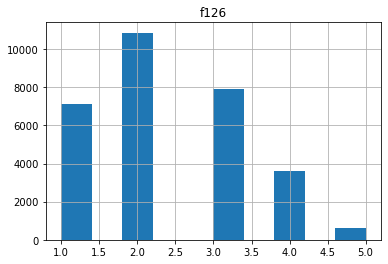

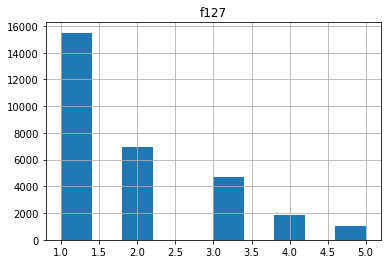

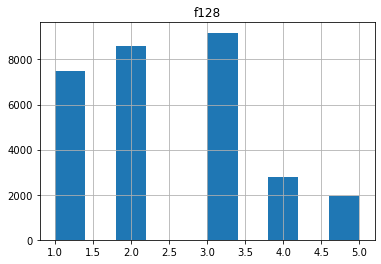

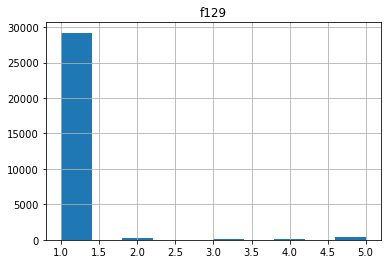

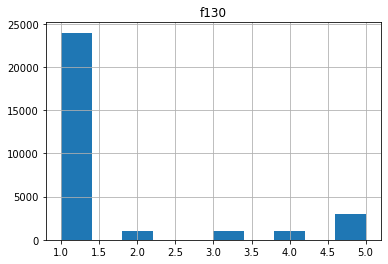

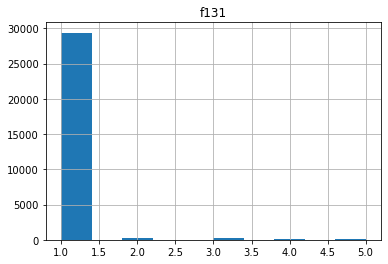

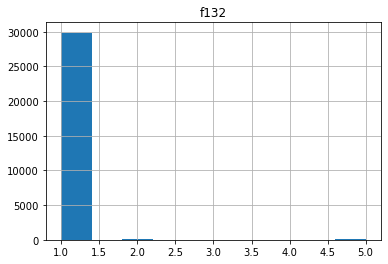

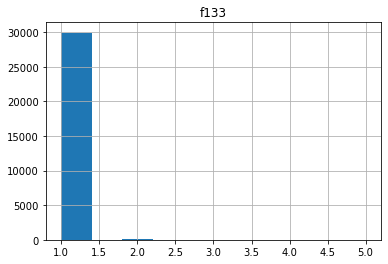

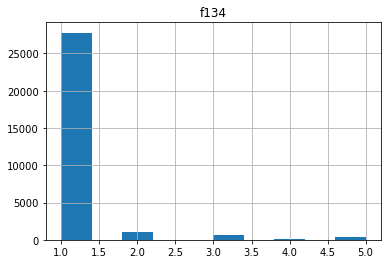

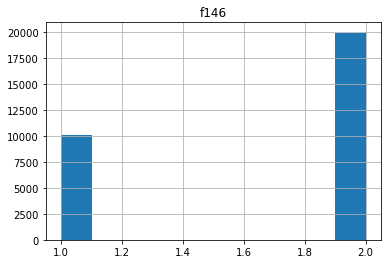

In [15]:
import matplotlib.pyplot as plt
for c in constants.ordinal_questions:
    plt.figure()
    df[c].hist()
    plt.title(c)
    print(df[c].describe())



## Cast "category" variables to float

In [16]:
def convert_to_float(df, columns):
    for c in columns:
        df[c] = df[c].astype(float)
    return df

#df = convert_to_int(df, constants.to_float_variables)

df = convert_to_float(df, df.select_dtypes(include=['category']).columns)

## Remove variables with very small variance

In [17]:
def handle_low_std_variables(df, threshold=0.02):
    low_var_found = [c for c in df.columns if df[c].std() < 0.01]
    if len(low_var_found) == 0:
        return df
    #print(f"The following variables have a std below {threshold}:\n{low_var_found}")
    for c in low_var_found:
        print(f"Removing {c} with value counts: \n{df[c].value_counts()}")
        df = df.drop(c, axis=1)
    return df

In [18]:
df = handle_low_std_variables(df)

Removing f41 with value counts: 
1.0    86
Name: f41, dtype: int64
Removing f49 with value counts: 
1.0    699
Name: f49, dtype: int64
Removing f145 with value counts: 
1.0    2072
Name: f145, dtype: int64
Removing f45_1 with value counts: 
0    30067
1        1
Name: f45_1, dtype: int64
Removing f45_3 with value counts: 
0    30066
1        2
Name: f45_3, dtype: int64
Removing f78_3_16 with value counts: 
0    30065
1        3
Name: f78_3_16, dtype: int64
Removing f78_3_18 with value counts: 
0    30067
1        1
Name: f78_3_18, dtype: int64
Removing f78_4_12 with value counts: 
0    30065
1        3
Name: f78_4_12, dtype: int64
Removing f78_4_13 with value counts: 
0    30065
1        3
Name: f78_4_13, dtype: int64
Removing f78_4_14 with value counts: 
0    30067
1        1
Name: f78_4_14, dtype: int64
Removing f78_4_17 with value counts: 
0    30066
1        2
Name: f78_4_17, dtype: int64
Removing f78_5_1 with value counts: 
0    30067
1        1
Name: f78_5_1, dtype: int64
Removin

In [19]:
# detect all non-int and non-float cols
"""
for col in df:
    if df[col].dtype not in ("float64", "int64"):
        print(col, df[col].dtype)
        non_na = df[col][~df[col].isna()]
        print("Len: ", len(non_na))
        print(non_na.head(3))
        if len(non_na.unique()) < 10:
            print("unique distrs:")
            for val in non_na.unique():
                print(val)
                print((non_na == val).mean())
        print()
"""

'\nfor col in df:\n    if df[col].dtype not in ("float64", "int64"):\n        print(col, df[col].dtype)\n        non_na = df[col][~df[col].isna()]\n        print("Len: ", len(non_na))\n        print(non_na.head(3))\n        if len(non_na.unique()) < 10:\n            print("unique distrs:")\n            for val in non_na.unique():\n                print(val)\n                print((non_na == val).mean())\n        print()\n'

### Make sure that the only remaining nans are within the interval questions (start with 'n')

In [20]:
for c in df.columns:
    if len(set(df[c].dropna())) == 1:
        df[c] = df[c].fillna(0)

In [22]:
has_nan = []
counter = 0
for c in df.columns:
    if df[c].isna().sum() > 0:
        print(c, df[c].isna().sum())
        counter += 1
        has_nan.append(c)
        
print(counter, "variables with nans")

nf33a 3238
nf33b 3238
nf34a 2713
nf34b 2713
nf35a 5877
nf35b 5877
nf36a 3504
nf36b 3504
nf42 27969
nf76 295
nf77 7606
nf82 4453
nf83 5242
nf84 4898
nf88 985
nf92 711
nf94 6134
nt1 213
nt2 1014
19 variables with nans


In [38]:
df['ges']

KeyError: 'ges'

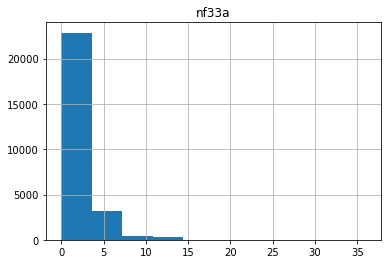

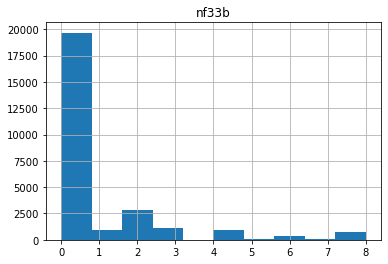

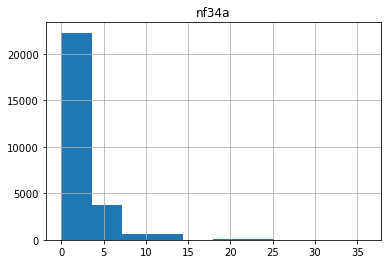

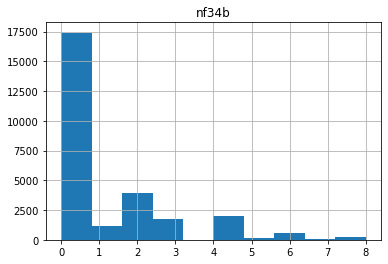

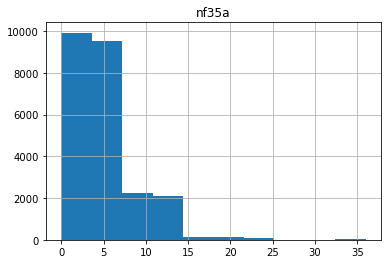

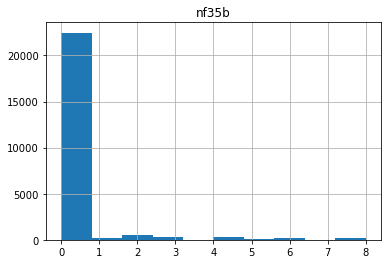

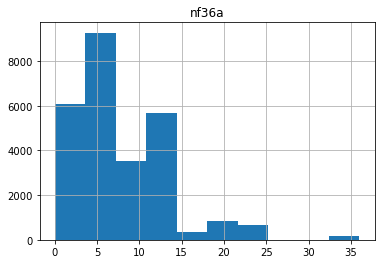

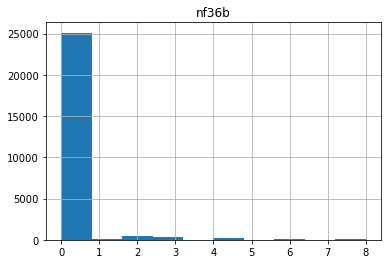

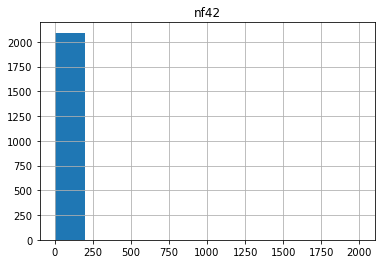

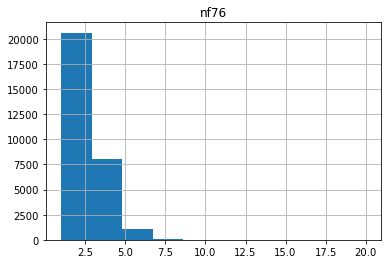

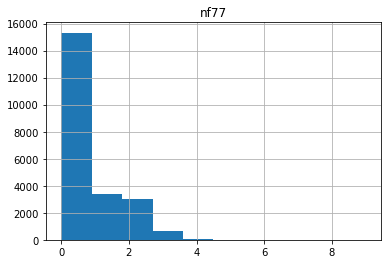

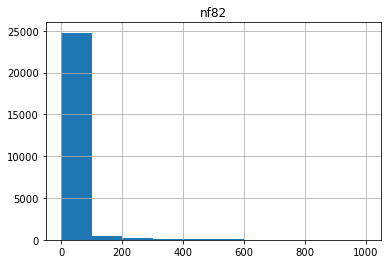

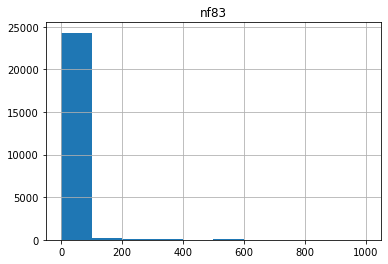

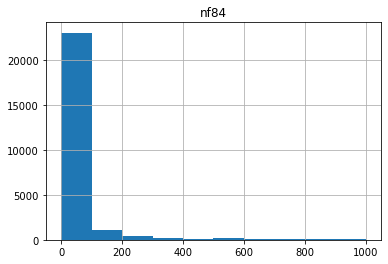

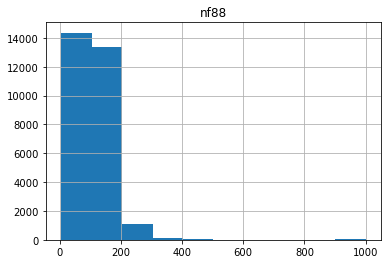

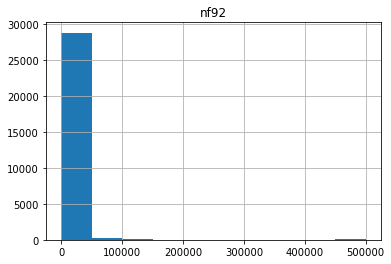

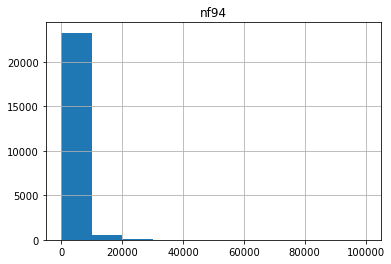

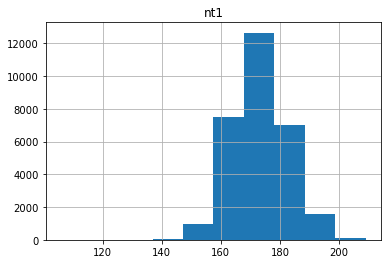

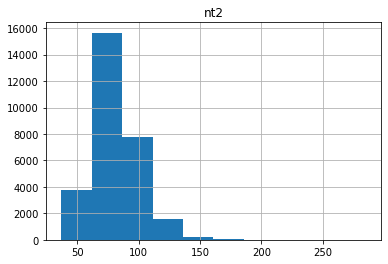

In [23]:
for c in constants.interval_questions:
    plt.figure()
    df[c].hist()
    plt.title(c)

## Investigate possible surrogate measures

In [24]:
df[constants.family_positive]

,f4a_1,f4a_2,f4a_3,f4a_4,f4b_1,f4b_2,f4b_3,f4b_4
0,0,0,1,0,0,0,1,0
1,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,1,0
3,0,0,1,0,0,0,1,0
4,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...
30063,0,0,1,0,0,0,1,0
30064,0,0,1,0,0,0,1,0
30065,0,0,1,0,0,0,1,0
30066,0,0,1,0,0,0,1,0


In [25]:
# family member in household tested positive (f4a_1), but no contact to positively tested person (f1a_1)
df.loc[(df['f4a_1'] == 1) & (df['f1a_1'] != 1), 'f4a_1']

518      1
2518     1
2630     1
3627     1
5685     1
6740     1
7004     1
8112     1
8738     1
9428     1
9468     1
11223    1
11921    1
13399    1
13582    1
16667    1
16988    1
21753    1
23916    1
24918    1
25125    1
26509    1
26825    1
27540    1
28128    1
28623    1
28742    1
29776    1
Name: f4a_1, dtype: int64

In [26]:
# family member in household tested positive (f4a_1), and also contact to positively tested person (f1a_1)
df.loc[(df['f4a_1'] == 1) & (df['f1a_1'] == 1), 'f4a_1']

1198     1
8078     1
10283    1
11291    1
16902    1
26696    1
28667    1
Name: f4a_1, dtype: int64

In [27]:
df.loc[:, constants.compound_label_cols_incl_diagnosed].describe()

,f1a_1,f1a_2,f1b_1,f1b_2,f2a_1,f2a_2,f2b_1,f2b_2
count,30068.000000,30068.000000,30068.000000,30068.000000,30068.000000,30068.000000,30068.000000,30068.000000
mean,0.018591,0.002561,0.055308,0.006419,0.000366,0.000565,0.002461,0.002727
std,0.135078,0.050541,0.228584,0.079861,0.019124,0.023772,0.049549,0.052152
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
def create_compound_label(df, columns):
    pos_class_idcs = df.index[df[columns].any(axis=1)].tolist()
    df["target"] = np.zeros(len(df))
    df.loc[pos_class_idcs, "target"] = 1.0
    print(f"Number of cases with positive target {len(pos_class_idcs)}")
    return df


In [29]:
df = create_compound_label(df, constants.compound_label_cols_incl_diagnosed)


Number of cases with positive target 2205


In [30]:
df = create_compound_label(df, constants.compound_label_cols_only_tested )


Number of cases with positive target 1988


In [31]:
df["f1a_1"].sum() 

559

In [32]:
df["f1a_2"].sum()

77

In [33]:
df["f1a_4"].sum()

248

In [34]:
(df["f1a_1"] + df["f1a_2"] + df["f1a_3"] + df["f1a_4"]).astype(bool).sum()

1286

In [35]:
(df["f1b_1"] + df["f1b_2"] + df["f1b_3"] + df["f1b_4"]).astype(bool).sum()

3520

In [36]:
(df["f1a_1"] + df["f1b_1"]).astype(bool).sum()

1961

In [37]:
((df["f2a"] == 1).astype(int) + (df["f2b"] == 1).astype(int) + df["f1a_1"] + df["f1b_1"]).astype(bool).sum()

KeyError: 'f2a'

In [ ]:
df.describe()
    

In [ ]:
len(df) - (28080 + 1906)

In [ ]:
df

In [ ]:
len(df)

In [ ]:
pred_df = df.copy()

In [ ]:
pred_df["target"] = ((df["f2a"] == 1).astype(int) + (df["f2b"] == 1).astype(int) + df["f1a_1"] + df["f1b_1"]).astype(bool)
drop_cols = [col for col in pred_df if "f1a" in col or "f2a" in col or "f2b" in col or "f1b" in col]
pred_df = pred_df.drop(columns=drop_cols)

In [ ]:
pred_df = pred_df.fillna(pred_df.median())

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

In [ ]:
from sklearn.model_selection import train_test_split
x = pred_df.drop(columns=["target", "sernr"])
labels = x.columns
y = pred_df["target"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
preds_test = clf.predict(x_test)

In [ ]:
(preds_test == y_test).mean()

In [ ]:
1 - y_test.mean()

In [ ]:
df_imps = pd.DataFrame({"imp": clf.feature_importances_, "feature": labels})

In [ ]:
df_imps.sort_values("imp")

In [ ]:
col_name = "f1a_5"
col = df[col]
print(col.iloc[0])
print(col.head())
print(col.tail())
print()
print(col.describe())
print()
if len(col.unique()) < 10:
    print("unique distrs:")
    for val in col.unique():
        print(val)
        print((col == val).mean())